In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import os
import csv
import itertools

from clusim.clustering import Clustering
from clusim.dag import Dendrogram
import clusim.sim as sim
import clusim.clusimelement as elsim

from sklearn.cluster import AgglomerativeClustering


import matplotlib.pylab as plt
import seaborn as sns
sns.set_style('white')


flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
cmap = sns.color_palette(flatui)


def GetHierCluster(data, membership, K = 4, metric = 'correlation', linkage_method = 'average'):
    ac = AgglomerativeClustering(n_clusters=K, 
                                 affinity=metric, 
                                linkage=linkage_method)
    return ac.fit_predict(data, membership)

def format_func(value, tick_number, labels, mask):
    if value in mask:
        return "%s" % labels[value]
    else:
        return ""

## Example 1

Evaluating clustering comparisons w.r.t. random models

In [3]:
# Load the Gene Expression Data

datafile = 'Data/risinger-2003_database.txt'

with open(datafile, 'r') as gefile:
    reader = csv.reader(gefile, delimiter="\t")
    d = [list(r) for r in reader]

membership = d[1]
membership.pop(0)
clusnames = {c:i for i, c in enumerate(set(membership))}
membership = [clusnames[n] for n in membership]

d = np.array(d[2:])
genetitles = d[:,0]
expressiondata = d[:,1:].astype(np.float)
K = len(clusnames)

ground_truth = Clustering()
ground_truth.from_membership_list(membership)



In [4]:
# find the Hierarchical Clustering
hierclus = Clustering()
hierclus.from_membership_list(GetHierCluster(expressiondata.T, membership, K))

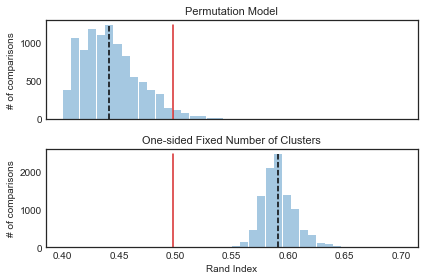

In [5]:

Nsamples = [100, 100**2]
model_list = ['perm', 'num1']
true_value = sim.rand_index(hierclus, ground_truth)

fig, ax = plt.subplots(2,1, sharex = True, figsize = (6, 4))
bins = np.linspace(0.4, 0.7, 41)

titles = ['Permutation Model', 'One-sided Fixed Number of Clusters']
for iax in range(2):
    pairwise_comparisons = sim.sample_expected_sim(hierclus, ground_truth, measure = 'rand_index', 
                                                       random_model = model_list[iax], 
                                                      nsamples = Nsamples[iax], keep_samples = True)
    
    rand_dist, bins = np.histogram(pairwise_comparisons, bins = bins)

    ax[iax].bar(0.5*(bins[:-1] + bins[1:]), rand_dist, width = 0.95*np.abs(bins[:-1] - bins[1:]), alpha = 0.4)
    
    exp_value = sim.expected_rand_index(ground_truth.n_elements, random_model = model_list[iax], 
                                         n_clusters1 = hierclus.n_clusters, 
                                         n_clusters2 = ground_truth.n_clusters, 
                                         clus_size_seq1 = hierclus.clus_size_seq, 
                                         clus_size_seq2 = ground_truth.clus_size_seq)
    
    ax[iax].plot([exp_value,exp_value], [0, rand_dist.max()], c = 'k', ls = '--')
    
    ax[iax].plot([true_value,true_value], [0, rand_dist.max()], c = sns.color_palette()[3])
    ax[iax].set_title(titles[iax], fontsize = 11)
    ax[iax].set_ylabel('# of comparisons', fontsize = 10)
    
ax[1].set_xlabel('Rand Index', fontsize = 10)

plt.tight_layout()
plt.show()

## Example 2

Element-centric comparisons of phylogenetic dendrograms.

In [6]:
# Load the Phylogenetic Trees

datafile = 'Data/song_mammals.424.gene.tre'

treestr_list = []
with open(datafile, 'r') as infile:
    for line in infile:
        treestr_list.append(line.replace('\n', ''))
        
Ngenetrees = len(treestr_list)
print("%d gene trees loaded" % Ngenetrees)

taxon_namespace = Dendrogram().infer_namespace(treestr_list[0])
clus2elm_dict = {str(n).replace("'",'').replace("_",' '):[str(n).replace("'",'').replace("_"," ")] for n in taxon_namespace}

424 gene trees loaded


In [7]:
# Compute the element-centric affinity matrices for different values of the scaling parameter

Nr = 40
rs = np.arange(-10, Nr -10)
alpha = 0.9
meanelsim = np.zeros((Nr,37))

for ir in range(Nr):
    print(ir,)
    afmat = []
    for itree in range(Ngenetrees):
        d = Dendrogram()
        d.from_newick(treestr_list[itree])
        d.norm_linkage()
        hc = Clustering(clus2elm_dict = clus2elm_dict, hier_graph = d)
        am = elsim.make_affinity_matrix(hc, alpha = alpha, r = rs[ir], 
                                         rescale_path_type = 'linkage', 
                                         relabeled_elements = None)
        afmat.append(am)
    
    num_comparisons = 0
    for itree, jtree in itertools.combinations(range(Ngenetrees), 2):
        meanelsim[ir] += elsim.cL1(afmat[itree], afmat[jtree], alpha = alpha)
        num_comparisons+= 1
    
    meanelsim[ir] = meanelsim[ir]/float(num_comparisons)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


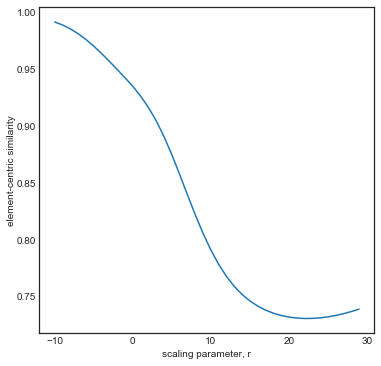

In [8]:
# Subfigure b
# The mean element-centric similarity between 424-gene trees reveals 
# few conflicts near the roots (left, r < 0), while decreasing similarity for increasing r 
# suggests greater conflicts towards the leaves (left, r > 0).

fig, ax = plt.subplots(1,1,figsize = (6,6))

ax.plot(rs, meanelsim.mean(axis = 1))

ax.set_xlabel('scaling parameter, r')
ax.set_xticks([-10,0,10,20,30])
ax.set_ylabel('element-centric similarity', labelpad = 0.4)


plt.show()

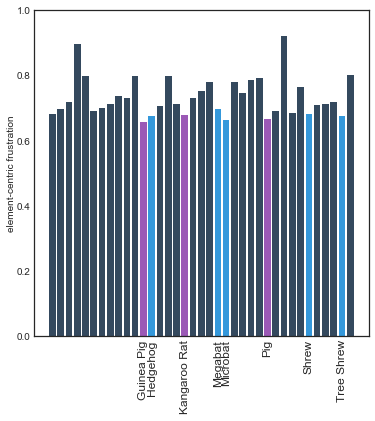

In [9]:
# subfigure c
# The element-centric frustration highlights 5 taxa previously identified with structural 
# discrepancies (bats, shrews, and hedgehog, blue, Mirarab et al., 2014), and the 3 taxa with 
# the smallest bootstrapping support in the maximum-pseudolikelihood coalescent tree (pig, 
# guinea pig, kangaroo rat, purple, Song et al., 2012)


fig, ax = plt.subplots(1,1,figsize = (6,6))

sample_elsim = meanelsim[29]

ax.bar(np.arange(len(sample_elsim)), sample_elsim, color = cmap[4])

songmask = [i for i,e in enumerate(sorted(hc.elements)) if 'Shrew' in e or 'bat' in e or ('Hedgehog' in e and not 'Less' in e)]
ax.bar(np.arange(len(sample_elsim))[songmask], sample_elsim[songmask], color = cmap[1])

mask2 = [i for i,e in enumerate(sorted(hc.elements)) if sample_elsim[i] < 0.68 and not i in songmask]
ax.bar(np.arange(len(sample_elsim))[mask2], sample_elsim[mask2], color = cmap[0])


ax.set_ylim([0.0, 1.0])
ax.set_ylabel('element-centric frustration', labelpad = 0.35)
labels = elsim.relabel_objects(hc.elements)
elidx = {i:e for e,i in labels.items()}

completemask = songmask + mask2

ax.set_xticks(range(len(sample_elsim)))
ax.set_xticklabels([elidx[i] for i in range(len(sample_elsim))], rotation = 90, ha = 'center', fontsize = 12)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda value, tick_number: format_func(value, tick_number, elidx, completemask)))

plt.show()
